El objetivo de este notebook es hacer una implementación rápida de MLP y ganar intuición sobre la forma de tomar las decisiones.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd "/content/drive/My Drive/repo_tesis/entorno_tesis_Molina"
!source bin/activate

Mounted at /content/drive
/content/drive/My Drive/repo_tesis/entorno_tesis_Molina


In [ ]:
!pip install comet_ml

In [ ]:
!pip install scikeras

In [ ]:
import numpy as np
import joblib
import sys
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
# from comet_ml import Experiment
import scikeras
import keras
from scikeras.wrappers import KerasClassifier
import tensorflow as tf
import time

In [ ]:
# Importar los datos
features = joblib.load("/content/drive/My Drive/repo_tesis/src/datos_definitivos/FEATURES_W200_I50.joblib")
label = joblib.load("/content/drive/My Drive/repo_tesis/src/datos_definitivos/label_W200_I50.joblib")

features_array = np.array(features)
label_array = np.array(label)

In [ ]:
# elijo esta particion en particular para hacer la prueba

%cd "/content/drive/My Drive/repo_tesis/src/ronda_experimentos_1/particiones_1subTest"

folds_ind = joblib.load('folds_W200_I50_sujetoTest_' + str(1) + '.pkl')
sujetos_array = joblib.load('arraySujetos_folds_W200_I50_sujetoTest_' + str(1) + '.pkl')

print(folds_ind)
print(sujetos_array)

/content/drive/My Drive/repo_tesis/src/ronda_experimentos_1/particiones_1subTest
[array([   0,    1,    2, ..., 5555, 5556, 5557]), array([ 5558,  5559,  5560, ..., 12118, 12119, 12120]), array([12121, 12122, 12123, ..., 17671, 17672, 17673]), array([17674, 17675, 17676, ..., 24621, 24622, 24623]), array([24624, 24625, 24626, ..., 31115, 31116, 31117]), array([31118, 31119, 31120, ..., 37990, 37991, 37992]), array([37993, 37994, 37995, ..., 44782, 44783, 44784]), array([44785, 44786, 44787, ..., 51319, 51320, 51321]), array([51322, 51323, 51324, ..., 57842, 57843, 57844]), array([57845, 57846, 57847, ..., 64523, 64524, 64525])]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


# Entrenamiento y resultados en test

In [ ]:
# Elijo como particionar los datos

# armo una lista del largo de los datos, en el que indico a que fold corresponde cada uno
# por el criterio elegido, se que el primer fold es para test, asi que lo saco
fold_test = folds_ind[0]

# me elijo un fold para validacion para esta prueba
fold_val = folds_ind[1]

# ahora lo quito para no armar entrevero
folds_ind = folds_ind[2:]
sujetos_train = sujetos_array[2:]   # me quedo solo con los sujetos que voy usar para train

In [ ]:
# Preparo los datos
# concateno y aplano la lista de arreglos
folds_ind_aplanado = np.concatenate(folds_ind).ravel()

X_val = features_array[fold_val, :]
y_val = label_array[fold_val, 1]

X_train = features_array[folds_ind_aplanado, :]
y_train = label_array[folds_ind_aplanado, 1]

In [ ]:
tf.random.set_seed(42)

arch = [250,500,250]
catNum = 13
featureNum = 16
inputDim = featureNum * 15 # 15 es la cantidad de features

# layers = [tf.keras.layers.Dense(arch[0], activation='relu', input_shape=(featureNum,))]
# for i in range(1,len(arch)-1):
#     layers.append(tf.keras.layers.Dense(arch[i], activation='relu'))
# layers.append(tf.keras.layers.Dense(catNum, activation='softmax'))
# self.clf = tf.keras.Sequential(layers)
# self.clf.compile(optimizer='adam',
#     loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
#     metrics=['accuracy'])

# model = tf.keras.Sequential()
# model.add(tf.keras.layers.Input(shape=[inputDim, ]))
# model.add(tf.keras.layers.Flatten())
# model.add(tf.keras.layers.Dense(300, activation="relu"))
# model.add(tf.keras.layers.Dense(100, activation="relu"))
# model.add(tf.keras.layers.Dense(catNum, activation="softmax"))

model = tf.keras.Sequential([
    tf.keras.layers.Dense(250, activation="relu", input_shape=(inputDim,)),
    tf.keras.layers.Dense(500, activation="relu"),
    tf.keras.layers.Dense(250, activation="relu"),
    tf.keras.layers.Dense(catNum, activation="softmax")
])

model.summary()


In [ ]:
model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer="sgd",
    metrics=["accuracy"]
)
# Define the checkpoint callback
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
    filepath="my_checkpoints.weights.h5",
    save_weights_only=True,
    save_best_only=True,
    monitor='val_loss',
    verbose=1
)

# Define the early stopping callback
early_stopping_cb = tf.keras.callbacks.EarlyStopping(
    patience=2,
    restore_best_weights=True,
    monitor='val_loss'
)

history = model.fit(
    X_train, y_train,
    epochs=10,
    validation_data=(X_val, y_val),
    callbacks=[checkpoint_cb, early_stopping_cb]
)
# history = model.fit()

Epoch 1/10
1635/1638 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.2008 - loss: 2.4099
Epoch 1: val_loss improved from inf to 1.96625, saving model to my_checkpoints.weights.h5
1638/1638 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.2010 - loss: 2.4095 - val_accuracy: 0.3209 - val_loss: 1.9663
Epoch 2/10
1634/1638 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.3643 - loss: 1.8835
Epoch 2: val_loss improved from 1.96625 to 1.92866, saving model to my_checkpoints.weights.h5
1638/1638 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.3643 - loss: 1.8834 - val_accuracy: 0.3169 - val_loss: 1.9287
Epoch 3/10
1637/1638 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4126 - loss: 1.7233
Epoch 3: val_loss did not improve from 1.92866
1638/1638 ━━━━━━━━━━━━━━━━━━━━ 20s 6ms/step - accuracy: 0.4126 - loss: 1.7233 - val_accuracy: 0.3174 - val_loss: 1.9919
Epoch 4/10
1631/1638 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4381 - loss: 1.6465
Epoch 4: val_loss did not improve from 1.92866
1638/1638 

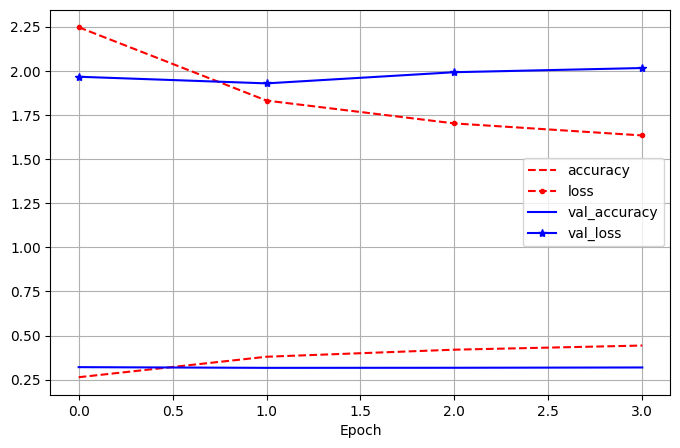

In [ ]:
pd.DataFrame(history.history).plot(
figsize=(8, 5), grid=True, xlabel="Epoch",  # xlim=[0, 9], ylim=[0, 1],
style=["r--", "r--.", "b-", "b-*"])
plt.show()

In [ ]:
model.save("my_keras_model.keras")

# Búsqueda de mejor modelo usando Early Stopping- 10 experimentos

## Separación de datos por sujeto

/content/drive/My Drive/repo_tesis/src/ronda_experimentos_1/particiones_1subTest


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
1598/1600 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.2127 - loss: 2.3951
Epoch 1: val_loss improved from inf to 2.09384, saving model to my_checkpoints0.weights.h5
1600/1600 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - accuracy: 0.2128 - loss: 2.3947 - val_accuracy: 0.3198 - val_loss: 2.0938
Epoch 2/50
1600/1600 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.3757 - loss: 1.8432
Epoch 2: val_loss improved from 2.09384 to 2.04176, saving model to my_checkpoints0.weights.h5
1600/1600 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - accuracy: 0.3757 - loss: 1.8432 - val_accuracy: 0.3362 - val_loss: 2.0418
Epoch 3/50
1591/1600 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4209 - loss: 1.6879
Epoch 3: val_loss did not improve from 2.04176
1600/1600 ━━━━━━━━━━━━━━━━━━━━ 20s 7ms/step - accuracy: 0.4210 - loss: 1.6877 - val_accuracy: 0.3286 - val_loss: 2.0890
Epoch 4/50
1596/1600 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.4407 - loss: 1.6117
Epoch 4: val_loss did not improve from 2.04176
1600/160

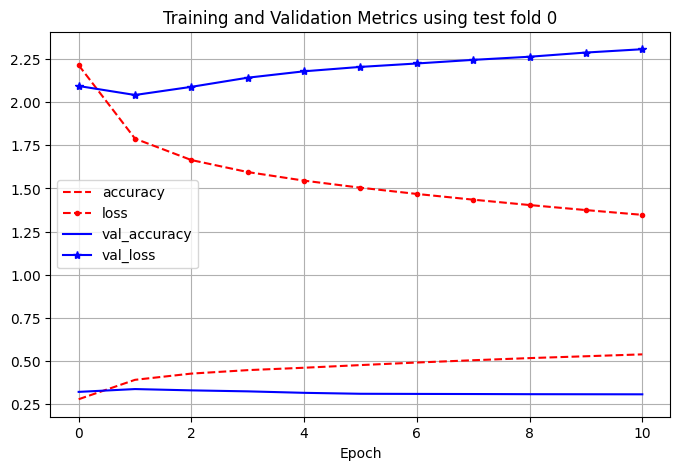

Training Accuracy: 0.4437
Validation Accuracy: 0.3286
Test Accuracy: 0.4773
1600/1600 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step
174/174 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
1590/1591 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.2179 - loss: 2.3941
Epoch 1: val_loss improved from inf to 2.00758, saving model to my_checkpoints1.weights.h5
1591/1591 ━━━━━━━━━━━━━━━━━━━━ 13s 8ms/step - accuracy: 0.2180 - loss: 2.3939 - val_accuracy: 0.3089 - val_loss: 2.0076
Epoch 2/50
1586/1591 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.3820 - loss: 1.8152
Epoch 2: val_loss did not improve from 2.00758
1591/1591 ━━━━━━━━━━━━━━━━━━━━ 20s 8ms/step - accuracy: 0.3820 - loss: 1.8151 - val_accuracy: 0.2740 - val_loss: 2.0325
Epoch 3/50
1586/1591 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.4210 - loss: 1.6709
Epoch 3: val_loss did not improve from 2.00758
1591/1591 ━━━━━━━━━━━━━━━━━━━━ 12s 8ms/step - accuracy: 0.4210 - loss: 1.6708 - val_accuracy: 0.2595 - val_loss: 2.0744
Epoch 4/50
1590/1591 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.4453 - loss: 1.5949
Epoch 4: val_loss did not improve from 2.00758
1591/1591 ━━━━━━━━━━━━━━━━━━━━ 21s 8ms/step - accuracy: 

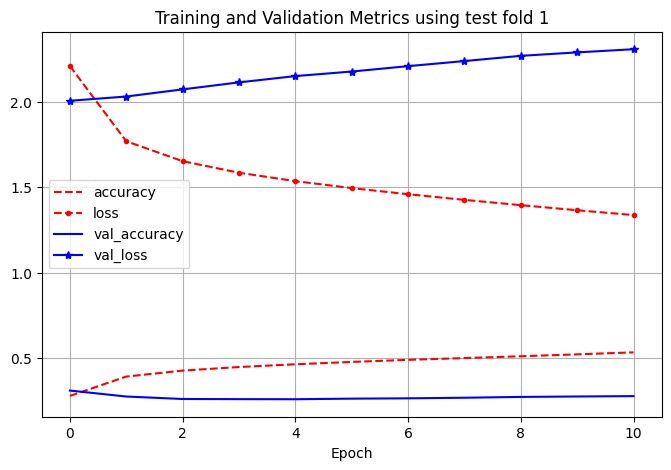

Training Accuracy: 0.4388
Validation Accuracy: 0.2595
Test Accuracy: 0.4691
1591/1591 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
1632/1634 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.2034 - loss: 2.4056
Epoch 1: val_loss improved from inf to 2.00140, saving model to my_checkpoints2.weights.h5
1634/1634 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.2036 - loss: 2.4053 - val_accuracy: 0.2727 - val_loss: 2.0014
Epoch 2/50
1634/1634 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.3843 - loss: 1.8220
Epoch 2: val_loss did not improve from 2.00140
1634/1634 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - accuracy: 0.3843 - loss: 1.8219 - val_accuracy: 0.2659 - val_loss: 2.0427
Epoch 3/50
1631/1634 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4256 - loss: 1.6702
Epoch 3: val_loss did not improve from 2.00140
1634/1634 ━━━━━━━━━━━━━━━━━━━━ 22s 7ms/step - accuracy: 0.4257 - loss: 1.6702 - val_accuracy: 0.2740 - val_loss: 2.1127
Epoch 4/50
1623/1634 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4467 - loss: 1.5952
Epoch 4: val_loss did not improve from 2.00140
1634/1634 ━━━━━━━━━━━━━━━━━━━━ 20s 7ms/step - accuracy: 

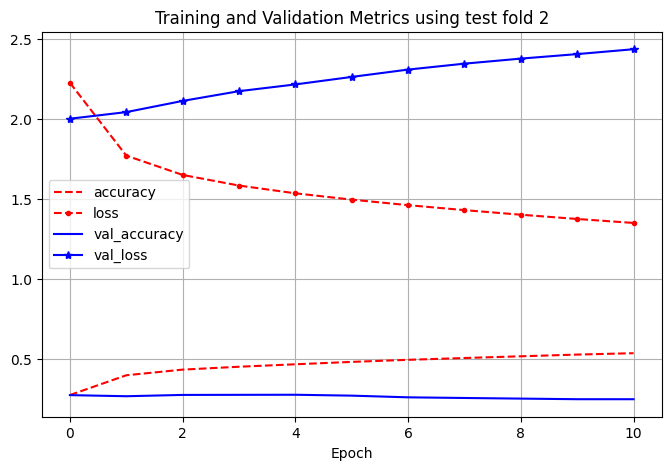

Training Accuracy: 0.4496
Validation Accuracy: 0.2740
Test Accuracy: 0.4497
1634/1634 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step
174/174 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
1600/1601 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.1994 - loss: 2.4046
Epoch 1: val_loss improved from inf to 2.12366, saving model to my_checkpoints3.weights.h5
1601/1601 ━━━━━━━━━━━━━━━━━━━━ 16s 9ms/step - accuracy: 0.1994 - loss: 2.4044 - val_accuracy: 0.2768 - val_loss: 2.1237
Epoch 2/50
1592/1601 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.3638 - loss: 1.8564
Epoch 2: val_loss improved from 2.12366 to 2.10986, saving model to my_checkpoints3.weights.h5
1601/1601 ━━━━━━━━━━━━━━━━━━━━ 17s 7ms/step - accuracy: 0.3639 - loss: 1.8561 - val_accuracy: 0.3120 - val_loss: 2.1099
Epoch 3/50
1598/1601 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.4027 - loss: 1.7106
Epoch 3: val_loss improved from 2.10986 to 2.09406, saving model to my_checkpoints3.weights.h5
1601/1601 ━━━━━━━━━━━━━━━━━━━━ 25s 10ms/step - accuracy: 0.4027 - loss: 1.7106 - val_accuracy: 0.3127 - val_loss: 2.0941
Epoch 4/50
1591/1601 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4286 - loss: 1.6336
Epoch 

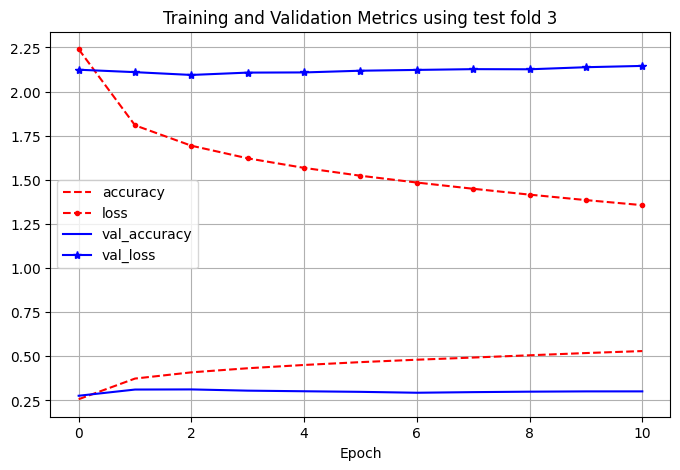

Training Accuracy: 0.3878
Validation Accuracy: 0.3127
Test Accuracy: 0.4010
1601/1601 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step
218/218 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1621/1626 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.2023 - loss: 2.4016
Epoch 1: val_loss improved from inf to 1.93491, saving model to my_checkpoints4.weights.h5
1626/1626 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - accuracy: 0.2026 - loss: 2.4009 - val_accuracy: 0.3363 - val_loss: 1.9349
Epoch 2/50
1622/1626 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.3660 - loss: 1.8582
Epoch 2: val_loss improved from 1.93491 to 1.92046, saving model to my_checkpoints4.weights.h5
1626/1626 ━━━━━━━━━━━━━━━━━━━━ 21s 7ms/step - accuracy: 0.3661 - loss: 1.8580 - val_accuracy: 0.3349 - val_loss: 1.9205
Epoch 3/50
1622/1626 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.3988 - loss: 1.7318
Epoch 3: val_loss improved from 1.92046 to 1.89709, saving model to my_checkpoints4.weights.h5
1626/1626 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - accuracy: 0.3988 - loss: 1.7317 - val_accuracy: 0.3456 - val_loss: 1.8971
Epoch 4/50
1625/1626 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4214 - loss: 1.6649
Epoch 4: val_loss 

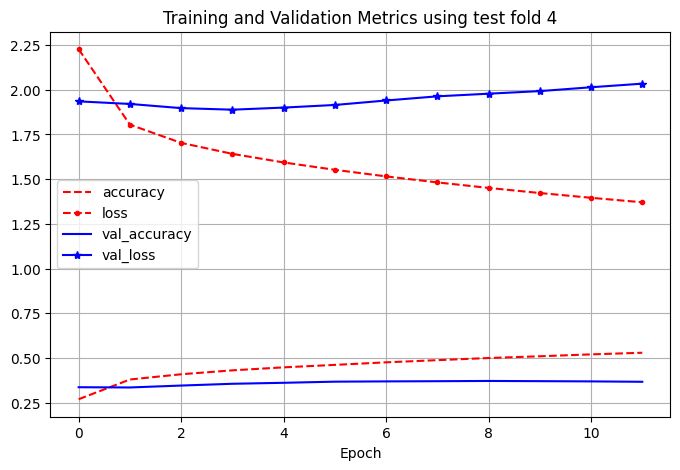

Training Accuracy: 0.4103
Validation Accuracy: 0.3555
Test Accuracy: 0.4532
1626/1626 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1608/1609 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.1953 - loss: 2.4107
Epoch 1: val_loss improved from inf to 2.16877, saving model to my_checkpoints5.weights.h5
1609/1609 ━━━━━━━━━━━━━━━━━━━━ 13s 8ms/step - accuracy: 0.1954 - loss: 2.4105 - val_accuracy: 0.2855 - val_loss: 2.1688
Epoch 2/50
1608/1609 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.3628 - loss: 1.8510
Epoch 2: val_loss did not improve from 2.16877
1609/1609 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - accuracy: 0.3628 - loss: 1.8509 - val_accuracy: 0.3001 - val_loss: 2.1940
Epoch 3/50
1604/1609 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4066 - loss: 1.6982
Epoch 3: val_loss did not improve from 2.16877
1609/1609 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - accuracy: 0.4066 - loss: 1.6981 - val_accuracy: 0.3071 - val_loss: 2.1936
Epoch 4/50
1608/1609 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4300 - loss: 1.6218
Epoch 4: val_loss did not improve from 2.16877
1609/1609 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - accuracy: 0.4300 - los

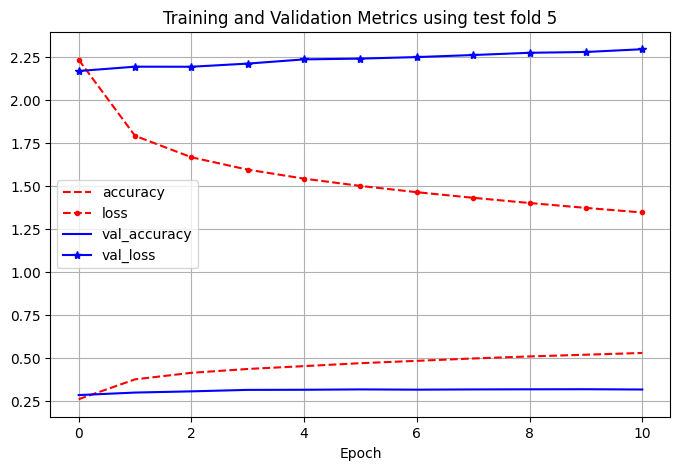

Training Accuracy: 0.4001
Validation Accuracy: 0.3071
Test Accuracy: 0.3495
1609/1609 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
1592/1597 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.2174 - loss: 2.3916
Epoch 1: val_loss improved from inf to 2.19107, saving model to my_checkpoints6.weights.h5
1597/1597 ━━━━━━━━━━━━━━━━━━━━ 14s 8ms/step - accuracy: 0.2176 - loss: 2.3909 - val_accuracy: 0.2304 - val_loss: 2.1911
Epoch 2/50
1595/1597 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.3856 - loss: 1.8062
Epoch 2: val_loss did not improve from 2.19107
1597/1597 ━━━━━━━━━━━━━━━━━━━━ 19s 7ms/step - accuracy: 0.3856 - loss: 1.8061 - val_accuracy: 0.2475 - val_loss: 2.2015
Epoch 3/50
1592/1597 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4235 - loss: 1.6791
Epoch 3: val_loss did not improve from 2.19107
1597/1597 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - accuracy: 0.4236 - loss: 1.6790 - val_accuracy: 0.2465 - val_loss: 2.2172
Epoch 4/50
1589/1597 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4499 - loss: 1.5986
Epoch 4: val_loss did not improve from 2.19107
1597/1597 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - accuracy: 0

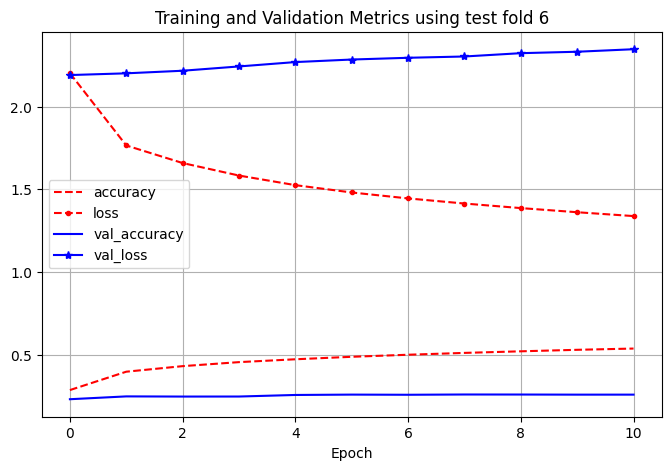

Training Accuracy: 0.4020
Validation Accuracy: 0.2465
Test Accuracy: 0.3620
1597/1597 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
1607/1609 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.2173 - loss: 2.4054
Epoch 1: val_loss improved from inf to 1.94148, saving model to my_checkpoints7.weights.h5
1609/1609 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.2175 - loss: 2.4051 - val_accuracy: 0.3614 - val_loss: 1.9415
Epoch 2/50
1605/1609 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.3739 - loss: 1.8700
Epoch 2: val_loss improved from 1.94148 to 1.91679, saving model to my_checkpoints7.weights.h5
1609/1609 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - accuracy: 0.3739 - loss: 1.8699 - val_accuracy: 0.3623 - val_loss: 1.9168
Epoch 3/50
1604/1609 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4119 - loss: 1.7210
Epoch 3: val_loss improved from 1.91679 to 1.90484, saving model to my_checkpoints7.weights.h5
1609/1609 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - accuracy: 0.4119 - loss: 1.7209 - val_accuracy: 0.3647 - val_loss: 1.9048
Epoch 4/50
1605/1609 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4324 - loss: 1.6467
Epoch 4

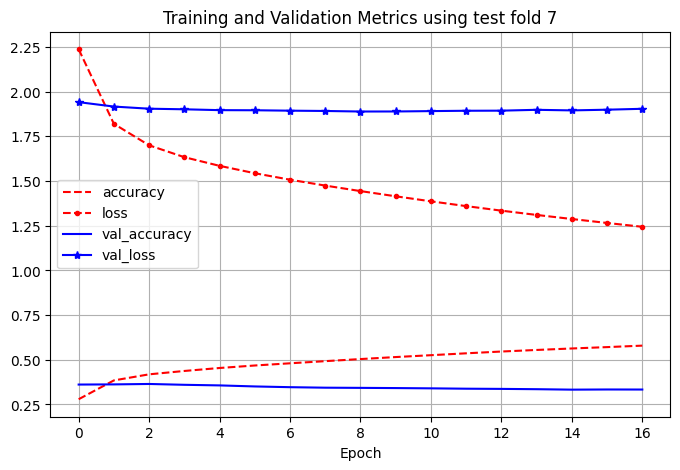

Training Accuracy: 0.4789
Validation Accuracy: 0.3429
Test Accuracy: 0.4305
1609/1609 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1598/1598 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.2041 - loss: 2.3974
Epoch 1: val_loss improved from inf to 2.16990, saving model to my_checkpoints8.weights.h5
1598/1598 ━━━━━━━━━━━━━━━━━━━━ 15s 9ms/step - accuracy: 0.2042 - loss: 2.3973 - val_accuracy: 0.2802 - val_loss: 2.1699
Epoch 2/50
1598/1598 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.3700 - loss: 1.8080
Epoch 2: val_loss improved from 2.16990 to 2.13431, saving model to my_checkpoints8.weights.h5
1598/1598 ━━━━━━━━━━━━━━━━━━━━ 19s 8ms/step - accuracy: 0.3700 - loss: 1.8079 - val_accuracy: 0.3183 - val_loss: 2.1343
Epoch 3/50
1596/1598 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4103 - loss: 1.6707
Epoch 3: val_loss did not improve from 2.13431
1598/1598 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - accuracy: 0.4103 - loss: 1.6707 - val_accuracy: 0.3286 - val_loss: 2.1387
Epoch 4/50
1594/1598 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4322 - loss: 1.5964
Epoch 4: val_loss did not improve from 2.13431
1598/1598 ━━━━━━━━━

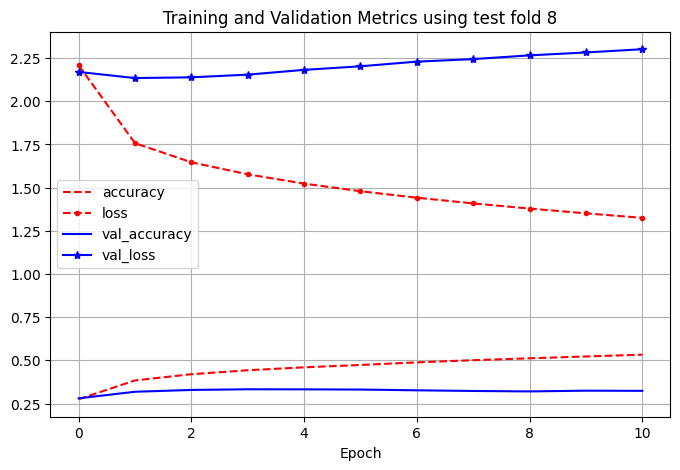

Training Accuracy: 0.4338
Validation Accuracy: 0.3286
Test Accuracy: 0.3751
1598/1598 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
1593/1599 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.2090 - loss: 2.3987
Epoch 1: val_loss improved from inf to 2.05088, saving model to my_checkpoints9.weights.h5
1599/1599 ━━━━━━━━━━━━━━━━━━━━ 13s 8ms/step - accuracy: 0.2093 - loss: 2.3980 - val_accuracy: 0.3266 - val_loss: 2.0509
Epoch 2/50
1598/1599 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.3804 - loss: 1.8165
Epoch 2: val_loss improved from 2.05088 to 1.98722, saving model to my_checkpoints9.weights.h5
1599/1599 ━━━━━━━━━━━━━━━━━━━━ 23s 9ms/step - accuracy: 0.3804 - loss: 1.8165 - val_accuracy: 0.3347 - val_loss: 1.9872
Epoch 3/50
1590/1599 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.4219 - loss: 1.6655
Epoch 3: val_loss did not improve from 1.98722
1599/1599 ━━━━━━━━━━━━━━━━━━━━ 18s 8ms/step - accuracy: 0.4220 - loss: 1.6654 - val_accuracy: 0.3311 - val_loss: 1.9992
Epoch 4/50
1591/1599 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.4482 - loss: 1.5865
Epoch 4: val_loss did not improve from 1.98722
1599/159

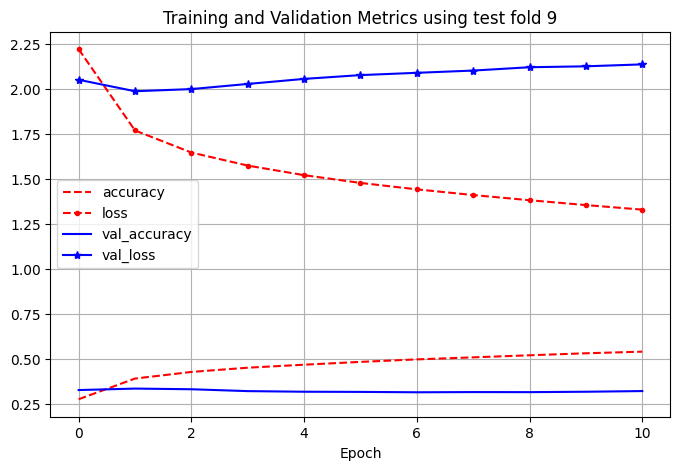

Training Accuracy: 0.4324
Validation Accuracy: 0.3311
Test Accuracy: 0.3811
1599/1599 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step
209/209 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


In [ ]:
%cd "/content/drive/My Drive/repo_tesis/src/ronda_experimentos_1/particiones_1subTest"

# parametros de mlp
tf.random.set_seed(42)

arch = [250,500,250]
catNum = 13
featureNum = 16
inputDim = featureNum * 15 # 15 es la cantidad de features

# metricas a guardar
precision_train = []
accuracy_train = []
accuracy_val = []
recall_train = []
precision_test = []
accuracy_test = []
recall_test = []
guardar_modelos = []
sujetos_test = []
tiempos_predict = []
cantidad_epocas_train = []
folds_val_experimento = []  # indica los folds que resultan del sorteo y se usan para validacion

for i in range(0, 10):
    folds_ind = joblib.load('folds_W200_I50_sujetoTest_' + str(i + 1) + '.pkl')
    sujetos_array = joblib.load('arraySujetos_folds_W200_I50_sujetoTest_' + str(i + 1) + '.pkl')
    sujetos_test.append(sujetos_array[0])
    fold_test = folds_ind[0]  # fold de test

    # voy a usar 2 folds para validacion, los cuales voy a sortear
    sorteo = np.random.permutation(len(folds_ind))
    folds_val = [folds_ind[sorteo[0]], folds_ind[sorteo[1]]]
    folds_val_experimento.append([sorteo[0], sorteo[1]]) # guardo el resultado del sorteo
    # creo una nueva lista excluyendo los elementos en los índices a remover
    folds_ind = [folds_ind[i] for i in range(len(folds_ind)) if i not in sorteo[:2]]

    # concateno folds de train
    folds_ind_train_array = np.concatenate(folds_ind).ravel()

    # concateno folds de train
    folds_ind_val_array = np.concatenate(folds_val).ravel()

    X_train = features_array[folds_ind_train_array, :]
    y_train = label_array[folds_ind_train_array, 1]
    X_val = features_array[folds_ind_val_array, :]
    y_val = label_array[folds_ind_val_array, 1]
    X_test = features_array[fold_test, :]
    y_test = label_array[fold_test, 1]

    # implemento mlp
    # defino arquitectura del modelo
    model = tf.keras.Sequential([
    tf.keras.layers.Dense(250, activation="relu", input_shape=(inputDim,)),
    tf.keras.layers.Dense(500, activation="relu"),
    tf.keras.layers.Dense(250, activation="relu"),
    tf.keras.layers.Dense(catNum, activation="softmax")
    ])
    model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer="sgd",
    metrics=["accuracy"]
    )
    # Define the checkpoint callback
    checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
        filepath="my_checkpoints" + str(i) + ".weights.h5",
        save_weights_only=True,
        save_best_only=True,
        monitor='val_loss',
        verbose=1
    )

    # Define the early stopping callback
    early_stopping_cb = tf.keras.callbacks.EarlyStopping(
        patience=8,
        restore_best_weights=True,
        monitor='val_loss',
        start_from_epoch=2
    )
    # defino callback personalizado para guardar cantidad de epocas que mejoran funcion de costo
    class EpochLogger(tf.keras.callbacks.Callback):
        def __init__(self):
            super(EpochLogger, self).__init__()
            self.epochs_improved = []

        def on_epoch_end(self, epoch, logs=None):
            current_val_loss = logs.get('val_loss')
            if not hasattr(self, 'best_val_loss'):
                self.best_val_loss = current_val_loss
                self.epochs_improved.append(epoch)
            else:
                if current_val_loss < self.best_val_loss:
                    self.best_val_loss = current_val_loss
                    self.epochs_improved.append(epoch)

    # Crear el logger de épocas
    epoch_logger = EpochLogger()


    # ajusto el modelo
    history = model.fit(
    X_train, y_train,
    epochs=50,
    validation_data=(X_val, y_val),
    callbacks=[checkpoint_cb, early_stopping_cb, epoch_logger]
    )

    # Obtener las épocas en las que mejoró la función de costo
    epochs_improved = epoch_logger.epochs_improved
    print(f"Épocas en las que mejoró la función de costo: {epochs_improved}")

    cantidad_epocas_train.append(epochs_improved[-1])

    pd.DataFrame(history.history).plot(
    figsize=(8, 5), grid=True, xlabel="Epoch",  # xlim=[0, 9], ylim=[0, 1],
    style=["r--", "r--.", "b-", "b-*"])
    plt.title("Training and Validation Metrics using test fold " + str(i))
    plt.show()

    model.save("my_keras_model"+ str(i) + ".keras")
    # fin implementacion mlp
    # Evaluate model on the training data
    train_loss, train_accuracy = model.evaluate(X_train, y_train, verbose=0)
    print(f"Training Accuracy: {train_accuracy:.4f}")

    # Evaluate model on the val data
    val_loss, val_accuracy = model.evaluate(X_val, y_val, verbose=0)
    print(f"Validation Accuracy: {val_accuracy:.4f}")

    # Evaluate model on the test data
    test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
    print(f"Test Accuracy: {test_accuracy:.4f}")

    # Make predictions on the training data
    y_train_pred = model.predict(X_train)
    y_train_pred_classes = y_train_pred.argmax(axis=1)

    # Make predictions on the test data
    start_time = time.time()
    y_test_pred = model.predict(X_test)
    end_time = time.time()
    testing_time = end_time - start_time
    tiempos_predict.append(testing_time)

    y_test_pred_classes = y_test_pred.argmax(axis=1)

    # No need to convert y_train and y_test since they are already in class label format
    y_train_classes = y_train
    y_test_classes = y_test

    # Calculate precision and recall on the training data
    train_precision = precision_score(y_train_classes, y_train_pred_classes, average='macro')
    train_recall = recall_score(y_train_classes, y_train_pred_classes, average='macro')

    # Calculate precision and recall on the test data
    test_precision = precision_score(y_test_classes, y_test_pred_classes, average='macro')
    test_recall = recall_score(y_test_classes, y_test_pred_classes, average='macro')

    precision_train.append(train_precision)
    precision_test.append(test_precision)
    accuracy_train.append(train_accuracy)
    accuracy_val.append(val_accuracy)
    accuracy_test.append(test_precision)
    recall_train.append(train_recall)
    recall_test.append(test_recall)

    # # Medir tiempo predict de muestras por separado
    # t_predict = np.zeros(len(X_test))
    # for m in range(len(t_predict)):
    #   print(m)
    #   start_time = time.time()
    #   pred = model.predict(X_test[m, :].reshape((1, X_test.shape[1])))
    #   end_time = time.time()
    #   training_time = end_time - start_time
    #   t_predict[m] = training_time

    # tiempos_predict.append([np.mean(t_predict), np.std(t_predict), np.max(t_predict), np.min(t_predict)])
    # guardar_modelos.append(full_pipeline)

In [ ]:
np.array(tiempos_predict)/6453

array([0.00014103, 0.0002116 , 0.00010844, 0.0001276 , 0.00020646,
       0.00020755, 0.0002227 , 0.00021044, 0.00020605, 0.00021099])

## Separación de datos por repetición

# Visualización de métricas

/content/drive/My Drive/repo_tesis/src/ronda_experimentos_1/particiones_1subTest


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
1405/1411 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.1979 - loss: 2.4208
Epoch 1: val_loss improved from inf to 2.02550, saving model to sep_rep_my_checkpoints0.weights.h5
1411/1411 ━━━━━━━━━━━━━━━━━━━━ 13s 8ms/step - accuracy: 0.1982 - loss: 2.4200 - val_accuracy: 0.3309 - val_loss: 2.0255
Epoch 2/50
1403/1411 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.3515 - loss: 1.9012
Epoch 2: val_loss improved from 2.02550 to 1.95736, saving model to sep_rep_my_checkpoints0.weights.h5
1411/1411 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - accuracy: 0.3516 - loss: 1.9008 - val_accuracy: 0.3197 - val_loss: 1.9574
Epoch 3/50
1405/1411 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3913 - loss: 1.7374
Epoch 3: val_loss improved from 1.95736 to 1.91876, saving model to sep_rep_my_checkpoints0.weights.h5
1411/1411 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.3914 - loss: 1.7373 - val_accuracy: 0.3362 - val_loss: 1.9188
Epoch 4/50
1406/1411 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4171 

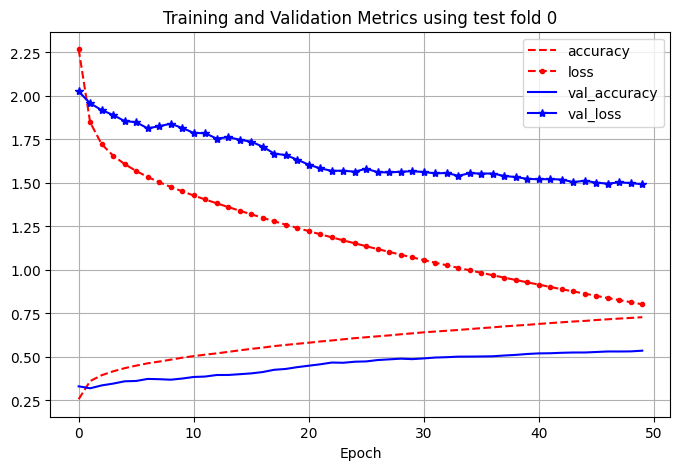

Training Accuracy: 0.6888
Validation Accuracy: 0.5358
Test Accuracy: 0.5081
1411/1411 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1394/1407 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.2016 - loss: 2.4127
Epoch 1: val_loss improved from inf to 2.07466, saving model to sep_rep_my_checkpoints1.weights.h5
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.2022 - loss: 2.4112 - val_accuracy: 0.2928 - val_loss: 2.0747
Epoch 2/50
1403/1407 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.3563 - loss: 1.9114
Epoch 2: val_loss did not improve from 2.07466
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - accuracy: 0.3563 - loss: 1.9112 - val_accuracy: 0.2274 - val_loss: 2.2185
Epoch 3/50
1400/1407 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3956 - loss: 1.7546
Epoch 3: val_loss did not improve from 2.07466
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.3956 - loss: 1.7545 - val_accuracy: 0.2253 - val_loss: 2.3599
Epoch 4/50
1406/1407 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4182 - loss: 1.6843
Epoch 4: val_loss did not improve from 2.07466
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - accuracy: 0.4182

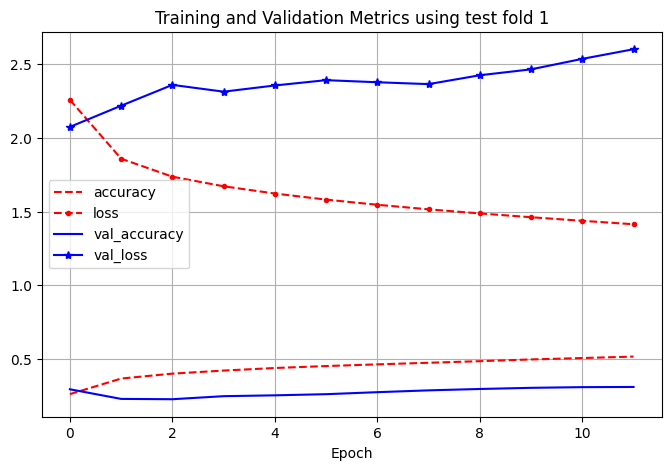

Training Accuracy: 0.2603
Validation Accuracy: 0.2460
Test Accuracy: 0.2786
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
1396/1405 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.1951 - loss: 2.4222
Epoch 1: val_loss improved from inf to 1.96672, saving model to sep_rep_my_checkpoints2.weights.h5
1405/1405 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.1956 - loss: 2.4212 - val_accuracy: 0.3270 - val_loss: 1.9667
Epoch 2/50
1401/1405 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.3594 - loss: 1.9037
Epoch 2: val_loss improved from 1.96672 to 1.82117, saving model to sep_rep_my_checkpoints2.weights.h5
1405/1405 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - accuracy: 0.3595 - loss: 1.9035 - val_accuracy: 0.3551 - val_loss: 1.8212
Epoch 3/50
1396/1405 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3917 - loss: 1.7557
Epoch 3: val_loss improved from 1.82117 to 1.77737, saving model to sep_rep_my_checkpoints2.weights.h5
1405/1405 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.3917 - loss: 1.7556 - val_accuracy: 0.3728 - val_loss: 1.7774
Epoch 4/50
1394/1405 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4130 

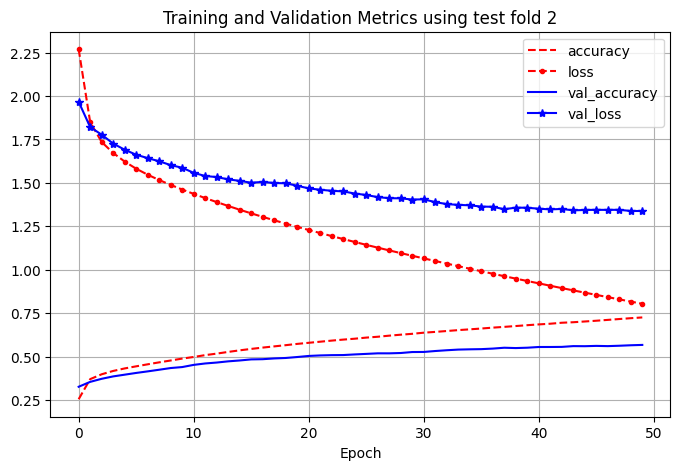

Training Accuracy: 0.7168
Validation Accuracy: 0.5658
Test Accuracy: 0.5144
1405/1405 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1414/1421 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.1984 - loss: 2.4178
Epoch 1: val_loss improved from inf to 2.06000, saving model to sep_rep_my_checkpoints3.weights.h5
1421/1421 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - accuracy: 0.1988 - loss: 2.4169 - val_accuracy: 0.2768 - val_loss: 2.0600
Epoch 2/50
1420/1421 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.3669 - loss: 1.8757
Epoch 2: val_loss did not improve from 2.06000
1421/1421 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.3669 - loss: 1.8756 - val_accuracy: 0.2808 - val_loss: 2.1347
Epoch 3/50
1417/1421 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.3991 - loss: 1.7320
Epoch 3: val_loss did not improve from 2.06000
1421/1421 ━━━━━━━━━━━━━━━━━━━━ 13s 7ms/step - accuracy: 0.3992 - loss: 1.7319 - val_accuracy: 0.2763 - val_loss: 2.2044
Epoch 4/50
1420/1421 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4211 - loss: 1.6649
Epoch 4: val_loss did not improve from 2.06000
1421/1421 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.421

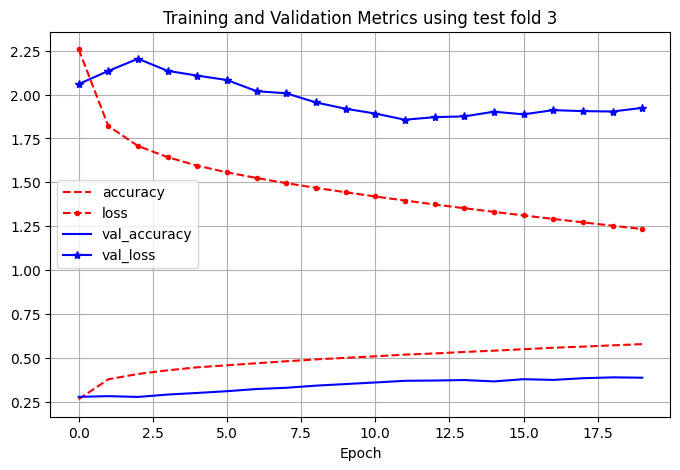

Training Accuracy: 0.4227
Validation Accuracy: 0.3682
Test Accuracy: 0.3833
1421/1421 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
1402/1407 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.1979 - loss: 2.4459
Epoch 1: val_loss improved from inf to 1.98893, saving model to sep_rep_my_checkpoints4.weights.h5
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 13s 9ms/step - accuracy: 0.1982 - loss: 2.4453 - val_accuracy: 0.3300 - val_loss: 1.9889
Epoch 2/50
1396/1407 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3653 - loss: 1.9066
Epoch 2: val_loss improved from 1.98893 to 1.78284, saving model to sep_rep_my_checkpoints4.weights.h5
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 0.3653 - loss: 1.9062 - val_accuracy: 0.3808 - val_loss: 1.7828
Epoch 3/50
1401/1407 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4006 - loss: 1.7377
Epoch 3: val_loss improved from 1.78284 to 1.71828, saving model to sep_rep_my_checkpoints4.weights.h5
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - accuracy: 0.4006 - loss: 1.7376 - val_accuracy: 0.3949 - val_loss: 1.7183
Epoch 4/50
1403/1407 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4235

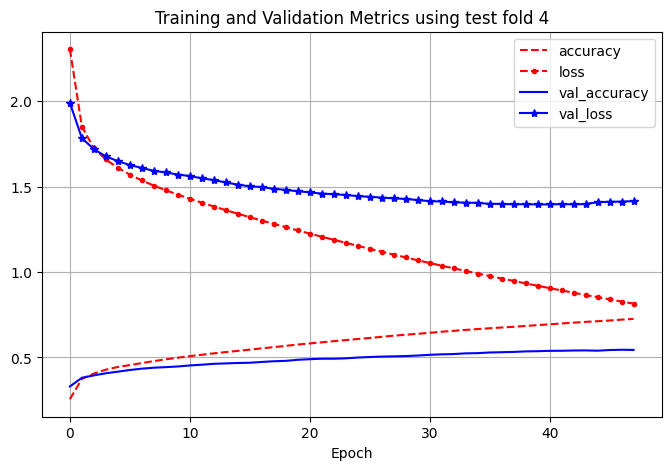

Training Accuracy: 0.6946
Validation Accuracy: 0.5364
Test Accuracy: 0.5498
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
1395/1407 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.1981 - loss: 2.4160
Epoch 1: val_loss improved from inf to 1.97799, saving model to sep_rep_my_checkpoints5.weights.h5
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - accuracy: 0.1987 - loss: 2.4146 - val_accuracy: 0.3493 - val_loss: 1.9780
Epoch 2/50
1404/1407 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3492 - loss: 1.8924
Epoch 2: val_loss improved from 1.97799 to 1.79374, saving model to sep_rep_my_checkpoints5.weights.h5
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.3493 - loss: 1.8923 - val_accuracy: 0.3907 - val_loss: 1.7937
Epoch 3/50
1404/1407 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3899 - loss: 1.7404
Epoch 3: val_loss improved from 1.79374 to 1.71857, saving model to sep_rep_my_checkpoints5.weights.h5
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 0.3899 - loss: 1.7403 - val_accuracy: 0.4146 - val_loss: 1.7186
Epoch 4/50
1396/1407 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4119 -

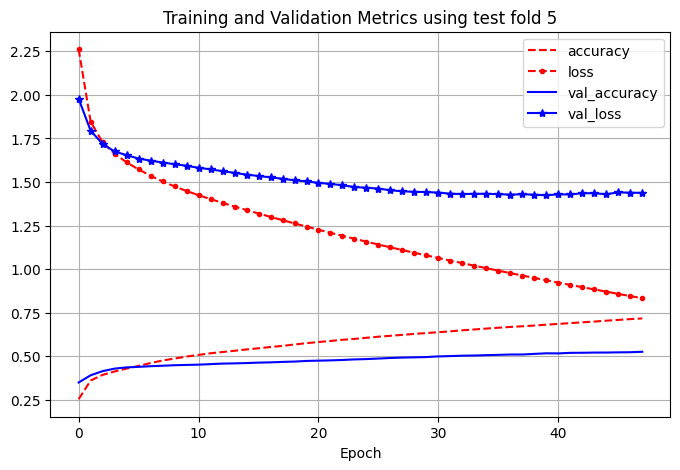

Training Accuracy: 0.6714
Validation Accuracy: 0.5168
Test Accuracy: 0.4984
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1399/1412 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.2042 - loss: 2.4329
Epoch 1: val_loss improved from inf to 2.10680, saving model to sep_rep_my_checkpoints6.weights.h5
1412/1412 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - accuracy: 0.2048 - loss: 2.4314 - val_accuracy: 0.2394 - val_loss: 2.1068
Epoch 2/50
1407/1412 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3571 - loss: 1.8923
Epoch 2: val_loss improved from 2.10680 to 1.93260, saving model to sep_rep_my_checkpoints6.weights.h5
1412/1412 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.3572 - loss: 1.8921 - val_accuracy: 0.3217 - val_loss: 1.9326
Epoch 3/50
1409/1412 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.3983 - loss: 1.7353
Epoch 3: val_loss improved from 1.93260 to 1.87517, saving model to sep_rep_my_checkpoints6.weights.h5
1412/1412 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - accuracy: 0.3983 - loss: 1.7353 - val_accuracy: 0.3451 - val_loss: 1.8752
Epoch 4/50
1409/1412 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4240 - loss: 1.6

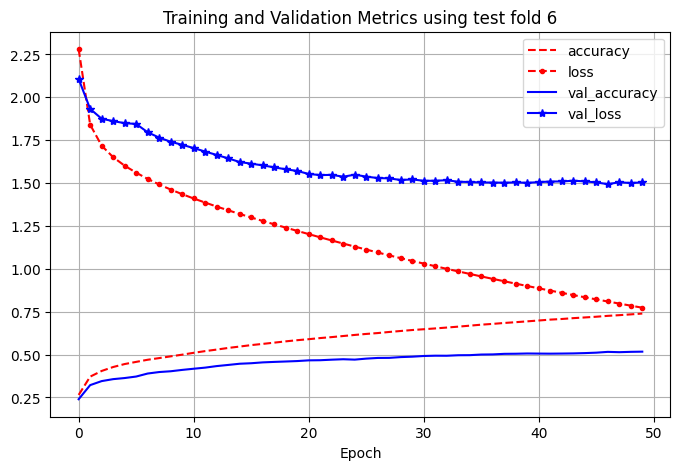

Training Accuracy: 0.7159
Validation Accuracy: 0.5156
Test Accuracy: 0.5599
1412/1412 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1405/1410 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.1893 - loss: 2.4307
Epoch 1: val_loss improved from inf to 2.02606, saving model to sep_rep_my_checkpoints7.weights.h5
1410/1410 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.1896 - loss: 2.4300 - val_accuracy: 0.3056 - val_loss: 2.0261
Epoch 2/50
1404/1410 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.3594 - loss: 1.9079
Epoch 2: val_loss improved from 2.02606 to 1.85929, saving model to sep_rep_my_checkpoints7.weights.h5
1410/1410 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - accuracy: 0.3594 - loss: 1.9076 - val_accuracy: 0.3472 - val_loss: 1.8593
Epoch 3/50
1406/1410 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3971 - loss: 1.7500
Epoch 3: val_loss improved from 1.85929 to 1.80245, saving model to sep_rep_my_checkpoints7.weights.h5
1410/1410 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.3972 - loss: 1.7499 - val_accuracy: 0.3639 - val_loss: 1.8025
Epoch 4/50
1410/1410 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4162 - loss: 1.68

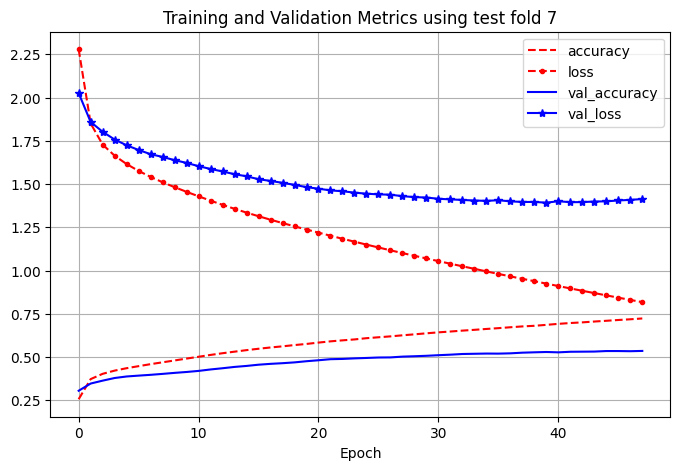

Training Accuracy: 0.6997
Validation Accuracy: 0.5295
Test Accuracy: 0.5819
1410/1410 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1405/1411 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.2086 - loss: 2.4070
Epoch 1: val_loss improved from inf to 1.98506, saving model to sep_rep_my_checkpoints8.weights.h5
1411/1411 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.2089 - loss: 2.4063 - val_accuracy: 0.3214 - val_loss: 1.9851
Epoch 2/50
1407/1411 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3587 - loss: 1.9026
Epoch 2: val_loss improved from 1.98506 to 1.79509, saving model to sep_rep_my_checkpoints8.weights.h5
1411/1411 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.3587 - loss: 1.9023 - val_accuracy: 0.3497 - val_loss: 1.7951
Epoch 3/50
1409/1411 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.3949 - loss: 1.7485
Epoch 3: val_loss improved from 1.79509 to 1.72399, saving model to sep_rep_my_checkpoints8.weights.h5
1411/1411 ━━━━━━━━━━━━━━━━━━━━ 13s 6ms/step - accuracy: 0.3949 - loss: 1.7485 - val_accuracy: 0.3741 - val_loss: 1.7240
Epoch 4/50
1405/1411 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4170 - loss: 1.

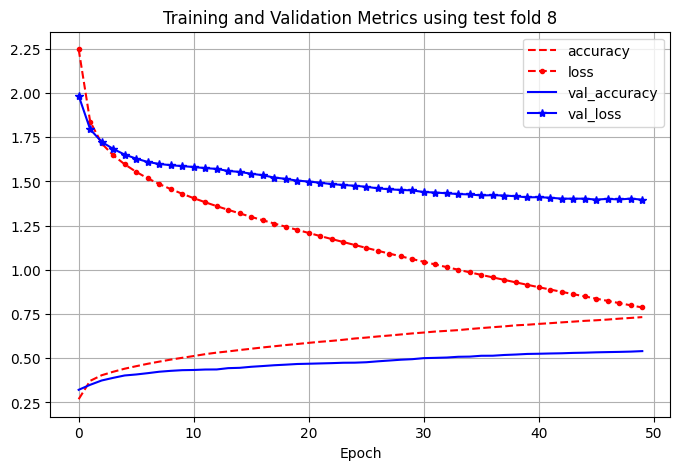

Training Accuracy: 0.7316
Validation Accuracy: 0.5403
Test Accuracy: 0.5455
1411/1411 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
1406/1412 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.1910 - loss: 2.4185
Epoch 1: val_loss improved from inf to 2.02270, saving model to sep_rep_my_checkpoints9.weights.h5
1412/1412 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - accuracy: 0.1913 - loss: 2.4178 - val_accuracy: 0.3177 - val_loss: 2.0227
Epoch 2/50
1409/1412 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.3467 - loss: 1.9373
Epoch 2: val_loss improved from 2.02270 to 1.79855, saving model to sep_rep_my_checkpoints9.weights.h5
1412/1412 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - accuracy: 0.3467 - loss: 1.9372 - val_accuracy: 0.3720 - val_loss: 1.7986
Epoch 3/50
1408/1412 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3905 - loss: 1.7673
Epoch 3: val_loss improved from 1.79855 to 1.73043, saving model to sep_rep_my_checkpoints9.weights.h5
1412/1412 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.3905 - loss: 1.7672 - val_accuracy: 0.3871 - val_loss: 1.7304
Epoch 4/50
1404/1412 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4094 

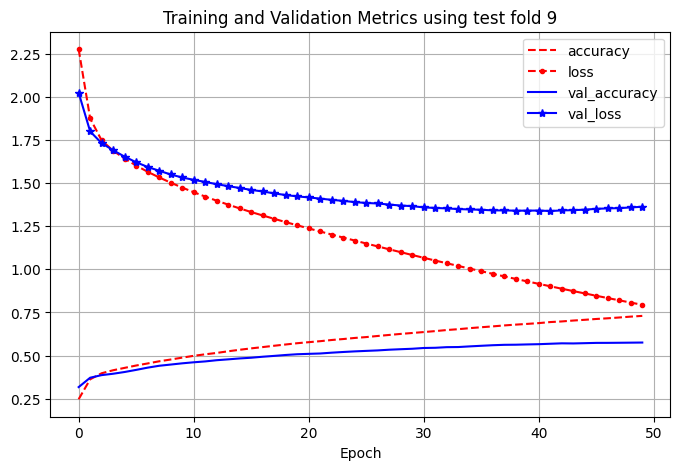

Training Accuracy: 0.6991
Validation Accuracy: 0.5688
Test Accuracy: 0.5618
1412/1412 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


In [ ]:
%cd "/content/drive/My Drive/repo_tesis/src/ronda_experimentos_1/particiones_1subTest"

folds_ind = joblib.load("10foldsXRepeticion_W200_I50.pkl")

folds_ind_array = []

for i in range(len(folds_ind)):
  folds_ind_array.append(np.array(folds_ind[i]))

folds_ind = folds_ind_array.copy()

# parametros de mlp
tf.random.set_seed(42)

arch = [250,500,250]
catNum = 13
featureNum = 16
inputDim = featureNum * 15 # 15 es la cantidad de features

# metricas a guardar
precision_train = []
accuracy_train = []
accuracy_val = []
recall_train = []
precision_test = []
accuracy_test = []
recall_test = []
guardar_modelos = []
sujetos_test = []
tiempos_predict = []
cantidad_epocas_train = []
folds_val_experimento = []  # indica los folds que resultan del sorteo y se usan para validacion

folds_num = np.arange(0,10)

for i in range(0, 10):
    # folds_ind = joblib.load('folds_W200_I50_sujetoTest_' + str(i + 1) + '.pkl')
    # sujetos_array = joblib.load('arraySujetos_folds_W200_I50_sujetoTest_' + str(i + 1) + '.pkl')
    sujetos_test.append(folds_num[i])
    folds_ind = folds_ind_array.copy()
    # por el criterio elegido, se que el primer fold es para test, asi que lo saco
    fold_test = folds_ind[i]

    # ahora lo quito para no armar entrevero
    folds_ind.pop(i)
    # voy a usar 2 folds para validacion, los cuales voy a sortear
    sorteo = np.random.permutation(len(folds_ind))
    folds_val = [folds_ind[sorteo[0]], folds_ind[sorteo[1]]]
    folds_val_experimento.append([sorteo[0], sorteo[1]]) # guardo el resultado del sorteo
    # creo una nueva lista excluyendo los elementos en los índices a remover
    folds_ind = [folds_ind[i] for i in range(len(folds_ind)) if i not in sorteo[:2]]

    # concateno folds de train
    folds_ind_train_array = np.concatenate(folds_ind).ravel()

    # concateno folds de train
    folds_ind_val_array = np.concatenate(folds_val).ravel()

    X_train = features_array[folds_ind_train_array, :]
    y_train = label_array[folds_ind_train_array, 1]
    X_val = features_array[folds_ind_val_array, :]
    y_val = label_array[folds_ind_val_array, 1]
    X_test = features_array[fold_test, :]
    y_test = label_array[fold_test, 1]

    # implemento mlp
    # defino arquitectura del modelo
    model = tf.keras.Sequential([
    tf.keras.layers.Dense(250, activation="relu", input_shape=(inputDim,)),
    tf.keras.layers.Dense(500, activation="relu"),
    tf.keras.layers.Dense(250, activation="relu"),
    tf.keras.layers.Dense(catNum, activation="softmax")
    ])
    model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer="sgd",
    metrics=["accuracy"]
    )
    # Define the checkpoint callback
    checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
        filepath="sep_rep_my_checkpoints" + str(i) + ".weights.h5",
        save_weights_only=True,
        save_best_only=True,
        monitor='val_loss',
        verbose=1
    )

    # Define the early stopping callback
    early_stopping_cb = tf.keras.callbacks.EarlyStopping(
        patience=8,
        restore_best_weights=True,
        monitor='val_loss',
        start_from_epoch=2
    )
    # defino callback personalizado para guardar cantidad de epocas que mejoran funcion de costo
    class EpochLogger(tf.keras.callbacks.Callback):
        def __init__(self):
            super(EpochLogger, self).__init__()
            self.epochs_improved = []

        def on_epoch_end(self, epoch, logs=None):
            current_val_loss = logs.get('val_loss')
            if not hasattr(self, 'best_val_loss'):
                self.best_val_loss = current_val_loss
                self.epochs_improved.append(epoch)
            else:
                if current_val_loss < self.best_val_loss:
                    self.best_val_loss = current_val_loss
                    self.epochs_improved.append(epoch)

    # Crear el logger de épocas
    epoch_logger = EpochLogger()
    # ajusto el modelo
    history = model.fit(
    X_train, y_train,
    epochs=50,
    validation_data=(X_val, y_val),
    callbacks=[checkpoint_cb, early_stopping_cb, epoch_logger]
    )

    # Obtener las épocas en las que mejoró la función de costo
    epochs_improved = epoch_logger.epochs_improved
    print(f"Épocas en las que mejoró la función de costo: {epochs_improved}")
    cantidad_epocas_train.append(epochs_improved[-1])

    pd.DataFrame(history.history).plot(
    figsize=(8, 5), grid=True, xlabel="Epoch",  # xlim=[0, 9], ylim=[0, 1],
    style=["r--", "r--.", "b-", "b-*"])
    plt.title("Training and Validation Metrics using test fold " + str(i))
    plt.show()

    model.save("sep_rep_my_keras_model"+ str(i) + ".keras")
    # fin implementacion mlp
    # Evaluate model on the training data
    train_loss, train_accuracy = model.evaluate(X_train, y_train, verbose=0)
    print(f"Training Accuracy: {train_accuracy:.4f}")

    # Evaluate model on the val data
    val_loss, val_accuracy = model.evaluate(X_val, y_val, verbose=0)
    print(f"Validation Accuracy: {val_accuracy:.4f}")

    # Evaluate model on the test data
    test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
    print(f"Test Accuracy: {test_accuracy:.4f}")

    # Make predictions on the training data
    y_train_pred = model.predict(X_train)
    y_train_pred_classes = y_train_pred.argmax(axis=1)

    # Make predictions on the test data
    start_time = time.time()
    y_test_pred = model.predict(X_test)
    end_time = time.time()
    testing_time = end_time - start_time
    tiempos_predict.append(testing_time)

    y_test_pred_classes = y_test_pred.argmax(axis=1)

    # No need to convert y_train and y_test since they are already in class label format
    y_train_classes = y_train
    y_test_classes = y_test

    # Calculate precision and recall on the training data
    train_precision = precision_score(y_train_classes, y_train_pred_classes, average='macro')
    train_recall = recall_score(y_train_classes, y_train_pred_classes, average='macro')

    # Calculate precision and recall on the test data
    test_precision = precision_score(y_test_classes, y_test_pred_classes, average='macro')
    test_recall = recall_score(y_test_classes, y_test_pred_classes, average='macro')

    precision_train.append(train_precision)
    precision_test.append(test_precision)
    accuracy_train.append(train_accuracy)
    accuracy_val.append(val_accuracy)
    accuracy_test.append(test_precision)
    recall_train.append(train_recall)
    recall_test.append(test_recall)

In [ ]:
# Si quiero levantar los archivos con las métricas
%cd "/content/drive/My Drive/repo_tesis/src/ronda_experimentos_1/hello_world/resultados_preliminares/con_PS"

metricas_sub = joblib.load('mlp_HW_NP_10_sep_sub_earlyStopping_trainTest_metricas.pkl')
metricas_rep = joblib.load('mlp_HW_NP_10_sep_rep_earlyStopping_trainTest_metricas.pkl')

/content/drive/My Drive/repo_tesis/src/ronda_experimentos_1/hello_world/resultados_preliminares/con_PS


In [ ]:
# Si lo tengo en la RAM, tambien me sirve para guardarlo

# # Cargar el modelo guardado
# model = tf.keras.models.load_model('my_keras_model0.keras')
# accuracy_val = accuracy_val[10:]
data = {'sujeto_test': sujetos_test,
        'accuracy_train': accuracy_train,
        'precision_train': precision_train,
        'recall_train': recall_train,
        'accuracy_val': accuracy_val,
        'accuracy_test': accuracy_test,
        'precision_test': precision_test,
        'recall_test': recall_test,
        'mean_score_time_x_dato': np.array(tiempos_predict)/6453,
        'epocas_entrenadas': cantidad_epocas_train,
        'folds_val': folds_val_experimento}
data = pd.DataFrame(data)

%cd "/content/drive/My Drive/repo_tesis/src/ronda_experimentos_1/particiones_1subTest"
joblib.dump(data, 'mlp_HW_NP_10_sep_rep_earlyStopping_trainTest_metricas.pkl')
data

/content/drive/My Drive/repo_tesis/src/ronda_experimentos_1/particiones_1subTest


,sujeto_test,accuracy_train,precision_train,recall_train,accuracy_val,accuracy_test,precision_test,recall_test,mean_score_time_x_dato,epocas_entrenadas,folds_val
0,0,0.688769,0.727031,0.686183,0.535821,0.566249,0.566249,0.507833,0.000109,49,"[7, 4]"
1,1,0.260324,0.407002,0.261957,0.245996,0.417677,0.417677,0.276965,0.000107,0,"[4, 6]"
2,2,0.716810,0.737018,0.716799,0.565785,0.544270,0.544270,0.517565,0.000108,48,"[8, 6]"
3,3,0.422737,0.591431,0.412738,0.368219,0.461844,0.461844,0.382216,0.000091,11,"[0, 3]"
4,4,0.694604,0.707523,0.690594,0.536386,0.554840,0.554840,0.543919,0.000128,39,"[2, 8]"
5,5,0.671429,0.689423,0.673903,0.516789,0.541548,0.541548,0.513348,0.000107,39,"[7, 6]"
6,6,0.715877,0.735848,0.716373,0.515588,0.581809,0.581809,0.563978,0.000210,46,"[2, 0]"
7,7,0.699749,0.721102,0.695583,0.529548,0.603857,0.603857,0.578659,0.000107,39,"[4, 2]"
8,8,0.731637,0.743638,0.731479,0.540296,0.555521,0.555521,0.544019,0.000209,49,"[2, 7]"
9,9,0.699110,0.722798,0.697309,0.568773,0.593748,0.593748,0.563975,0.000207,41,"[1, 6]"


In [ ]:
# Visualizo las métricas que haya levantado
metricas_sub.loc[:, ['sujeto_test', 'accuracy_train', 'accuracy_val', 'accuracy_test', 'mean_score_time_x_dato', 'epocas_entrenadas']]
# metricas_rep

,sujeto_test,accuracy_train,accuracy_val,accuracy_test,mean_score_time_x_dato,epocas_entrenadas
0,0,0.411586,0.346248,0.438764,0.000212,2
1,1,0.444151,0.374880,0.451796,0.000123,2
2,2,0.394595,0.319967,0.499742,0.000218,1
3,3,0.425491,0.347062,0.566926,0.000127,2
4,4,0.413838,0.257381,0.359553,0.000108,1
5,5,0.236516,0.192871,0.123721,0.000112,0
6,6,0.480365,0.380393,0.562544,0.000115,6
7,7,0.479706,0.352608,0.558711,0.000110,7
8,8,0.384834,0.270581,0.400124,0.000112,0
9,9,0.390214,0.334567,0.416845,0.000208,1


In [ ]:
metricas_sub = metricas_sub.rename(columns={'mean_score_time_x_dato:': 'mean_score_time_x_dato'})
metricas_rep = metricas_rep.rename(columns={'mean_score_time_x_dato:': 'mean_score_time_x_dato'})

In [ ]:
%cd "/content/drive/My Drive/repo_tesis/src/ronda_experimentos_1/hello_world/resultados_preliminares/con_PS"

joblib.dump(metricas_sub, 'mlp_HW_NP_10_sep_sub_earlyStopping_trainTest_metricas.pkl')
joblib.dump(metricas_rep, 'mlp_HW_NP_10_sep_rep_earlyStopping_trainTest_metricas.pkl')

/content/drive/My Drive/repo_tesis/src/ronda_experimentos_1/hello_world/resultados_preliminares/con_PS


['mlp_HW_NP_10_sep_rep_earlyStopping_trainTest_metricas.pkl']